Spectroscopic data reduction in six simple steps. The steps performed in this notebook are shown in **bold.**

Step 1: Trim and subtract bias from all the data.

Step 2: Flatfield the data.

Step 3: Construct a comparison lamp image from separate He and Ne lamps.

**Step 4: Fit the wavelength solution to the lamp composite.** 

Step 5: Extract the 1-D spectrum and its wavelength solution.

Step 6: Apply a relative flux calibration. 

$\rightarrow$ now you are ready to do a bit of analysis.

Piece of cake. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D, Polynomial2D, Chebyshev2D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter
from astropy.io import ascii
from astropy.table import Table

from scipy import ndimage

# getting used to wavelength calibration

Matching observed spectral lines to an atlas of known lines is hard and takes experience. To get a feel for how this process works, let's start with just a few lines observed with the He lamp. 

In [2]:
# the long He lamp that has been trimmed and bias-subtracted 
lab2tb_he_long = fits.open('lab2tb_he_long.fits')[0].data

In [3]:
# Get the median along the spectral direction
spec = np.median(lab2tb_he_long, axis=0)
# define the x-axis in pixel space 
xspec = np.arange(len(spec))

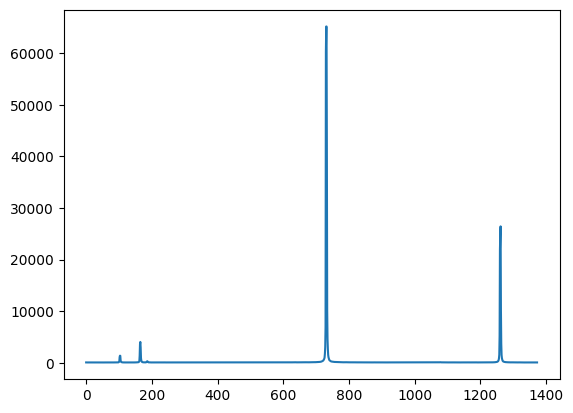

In [4]:
plt.plot(spec)

Next, we need a list of known He I lines, preferably with the relative intensities to make it a bit easier to determine which line is which. We'll use a pre-existing line list to do this. 

In [5]:
# pull the He I line list
HeI_lines = Table.read('../hei_linelist.dat', format='ascii', data_start=1,
                      names=['wave', 'ints'])

Print out the list to see the wavelength in Angstroms and the relative intensity. 

In [6]:
HeI_lines.pprint_all()

   wave    ints
--------- -----
2818.1895  10.0
2945.1199  10.0
3013.7332  40.0
  3187.75  20.0
3819.5928  10.0
3888.6313 500.0
3964.7104  20.0
 4026.171  50.0
4120.7925  12.0
4387.9004  10.0
4471.4487 200.0
4713.1084  30.0
 4921.889  20.0
5015.6343 100.0
 5047.693  10.0
 5875.559 500.0
 6678.074 100.0
7281.2607  50.0


Next, we have to figure out which lines in the data correspond to which He I lines. Hopefully we know something about our observations (for example, the approximate wavelength range of our observations). Then, we make an educated guess based on the known wavelengths and relative intensities of the He I lines. 

In [7]:
# guess the central position of the non-saturated lines 
peaks = [103, 165, 186, 1262]
guessed_wavelengths = [4921.889, 5015.6343, 5047.693, 6678.074]

We can improve the x pixel values by using the intensity-weighted position (moment 1). 

In [8]:
npixels = 15
peaks_refined = [np.average(xspec[g-npixels:g+npixels],
                            weights=spec[g-npixels:g+npixels] - np.median(spec))
                 for g in peaks]
peaks_refined

[103.35643135556518,
 164.96532246532246,
 183.57129714811407,
 1261.3157305952036]

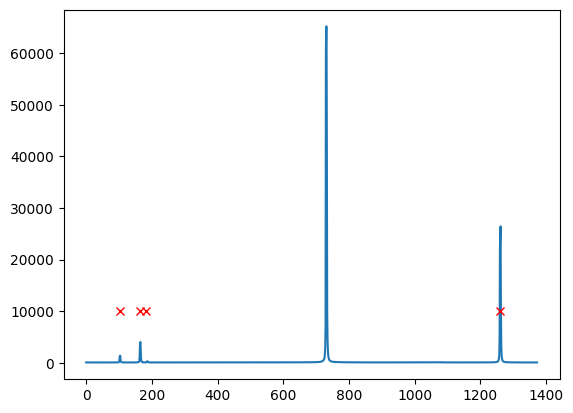

In [9]:
plt.plot(spec)
plt.plot(peaks_refined, [10000]*len(peaks_refined), 'x', color='red')

We only have a few points, so let's fit a linear model. We exclude the saturated line from our fit because it's saturated (so the line profile is flat-topped and the line center is poorly constrained). We can use this later as a sanity check -- we expect this to the brightest line in this portion of the He I spectrum (which line?). 

In [10]:
linfitter = LinearLSQFitter()
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=peaks_refined, y=guessed_wavelengths)
wavelengths = linfit_wlmodel(np.arange(len(spec))) * u.AA
linfit_wlmodel

<Linear1D(slope=1.51544018, intercept=4766.75621942)>

We can plot the spectrum with our newly-derived wavelength solution to see how we did. 

(-100.0, 10000.0)

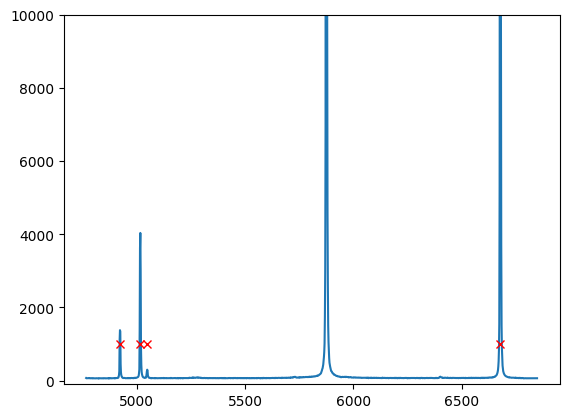

In [11]:
plt.plot(wavelengths, spec)
plt.plot(guessed_wavelengths, [1000]*4, 'x', color='red')
plt.ylim([-100,10000])

Let's look at how well a linear model fits the data. 

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_25106/252558879.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

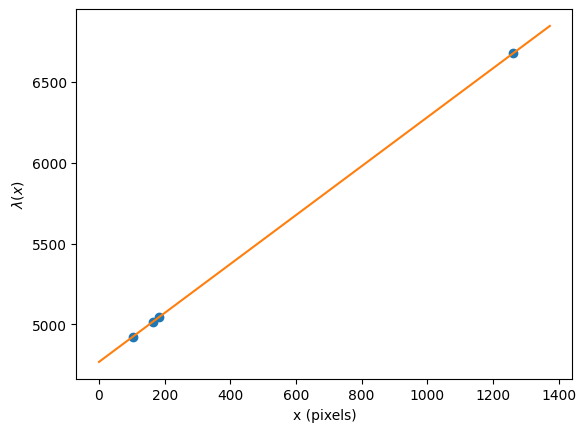

In [12]:
# input guesses 
plt.plot(peaks_refined, guessed_wavelengths, 'o')
# derived wavelength solution
plt.plot(np.arange(len(spec)), wavelengths)
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

The last things to check is whether this wavelength solution correctly identifies the saturated line as the brightest line in this portion of the He I spectrum (the line with the highest relative intensity).

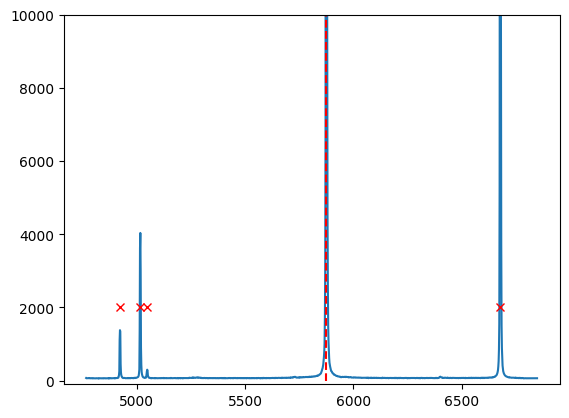

In [13]:
plt.plot(wavelengths, spec)
plt.plot(guessed_wavelengths, [2000]*4, 'x', color='red')
plt.ylim([-100,10000])
plt.plot([5875.559,5875.559],[0,10000], color='red', linestyle='dashed')

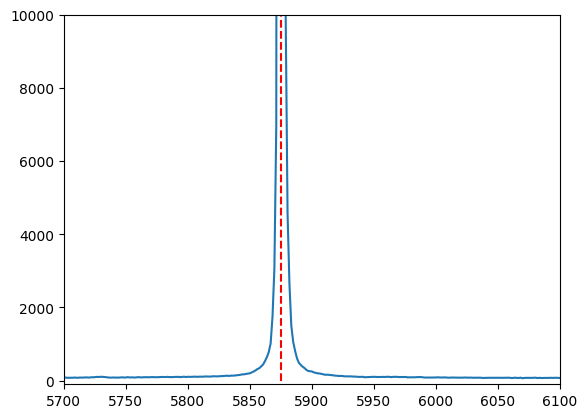

In [14]:
plt.plot(wavelengths, spec)
plt.plot(guessed_wavelengths, [2000]*4, 'x', color='red')
plt.xlim([5700,6100])
plt.ylim([-100,10000])
plt.plot([5875.559,5875.559],[0,10000], color='red', linestyle='dashed')

Now that we have a feel for how wavelength calibration works, let's do the full composite lamp. It has more lines giving us a better fit and a more robust wavelength solution. 

# Fit the full calibration spectrum 

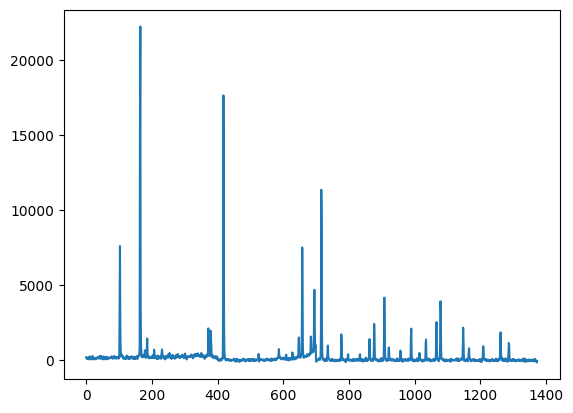

In [15]:
# read in our combined lamp spectrum 
spectrum2D = fits.open("lamp_spec.fits")[0].data

# Take a slice along the middle of the 2D spectrum
middle = 300 
spectrum = spectrum2D[middle,:]
xaxis = np.arange(len(spectrum))
plt.plot(xaxis, spectrum)

We have a bespoke line list for our combined calibration spectrum. Take a look at the file -- it has two columns: wavelengths and the name of the atom. 

In [16]:
# read in the line list 
linelist = Table.read('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/shelyaklowres.dat', format='ascii.basic', 
                     data_start=2, names=['wave', 'line']) #, guess=False)

In [17]:
linelist.pprint()

   wave      line  
--------- ---------
3948.9789       ArI
4026.1914       HeI
4044.4179       ArI
 4120.815       HeI
4158.5907       ArI
4181.8836       ArI
 4190.818 ArI_blend
      ...       ...
7503.8691       ArI
7514.6518       ArI
7535.7739       NeI
7544.0443       NeI
 7635.106       ArI
 7891.075       ArI
7948.1764       ArI
Length = 74 rows


We have to play the same game here -- identify a few lines to get a first estimate of the wavelength solution. Ideally, we'd identify 1-2 lines on either end, and 3-4 in the middle. This part should be straightforward since we have an image of the lamp spectra with all of the lines identified. See the last page of the https://www.ruf.rice.edu/~ruco/SHELYAKIII.pdf. 

In [18]:
xvals = [103, 165, 990, 1262, 1287]
more_guessed_wavelengths = [4921.889, 5015.6343, 6266.495, 6678.276, 6717.043]
# HeI, HeI, NeI, HeI, NeI 

In [19]:
npixels = 9
better_xvals = [np.average(xspec[g-npixels:g+npixels],
                            weights=spectrum[g-npixels:g+npixels] - np.median(spectrum))
                 for g in xvals]
better_xvals

[103.10711010576512,
 164.70304948823468,
 989.1472868217054,
 1261.7349804941482,
 1288.0100558659217]

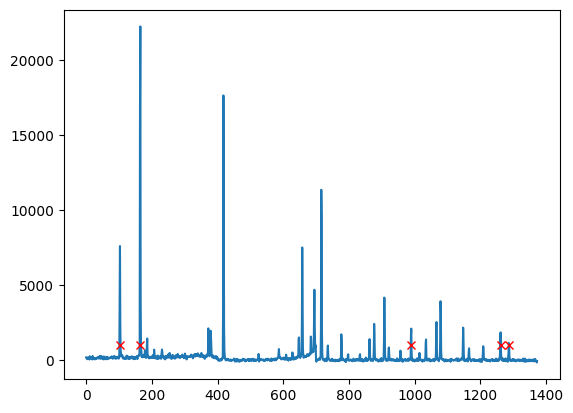

In [20]:
plt.plot(spectrum)
plt.plot(better_xvals, [1000]*len(better_xvals), 'x', color='red')

Redo the linear fit to see if we are on track. If we've identified the lines correctly, the points should lie close to the line. Misidentifications show up as points that are waaay off the line. 

In [21]:
# try a linear model first to see if we have identified the lines correctly 
linfit_wlmodel_full = linfitter(model=wlmodel, x=better_xvals, y=more_guessed_wavelengths)
more_wavelengths = linfit_wlmodel_full(np.arange(len(spectrum))) * u.AA
linfit_wlmodel_full

<Linear1D(slope=1.51558858, intercept=4765.98849569)>

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_25106/2593512324.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

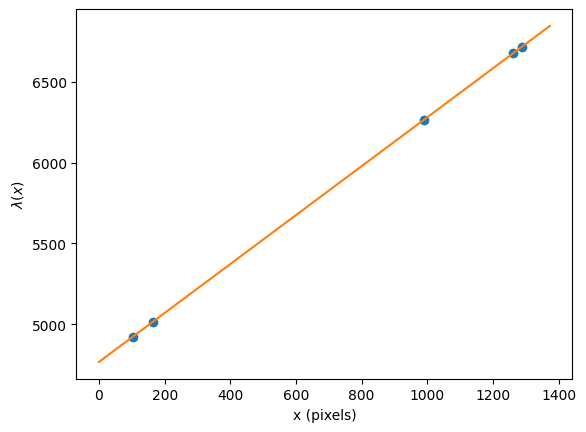

In [22]:
# input guesses 
plt.plot(better_xvals, more_guessed_wavelengths, 'o')
# derived wavelength solution
plt.plot(np.arange(len(spectrum)), more_wavelengths)
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

We can use this linear wavelength solution that we just computed to estimate the position of the other lines in our combined lamp spectrum. 

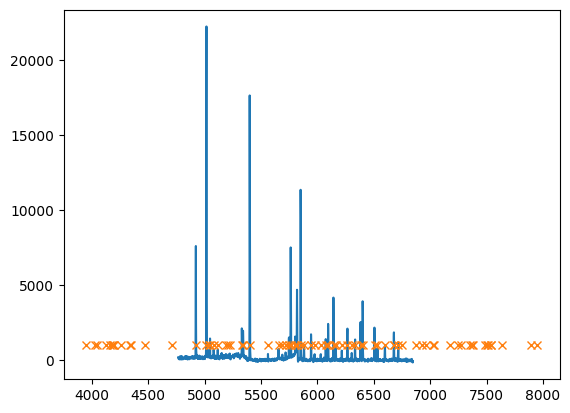

In [23]:
# use the linear fit from the HeI lamp to estimate the wavelength solution. 
#all_wavelengths = linfit_wlmodel(np.arange(len(spectrum))) * u.AA
all_wavelengths = linfit_wlmodel_full(np.arange(len(spectrum))) * u.AA

plt.plot(all_wavelengths, spectrum)
plt.plot(linelist['wave'], [1000]*len(linelist['wave']), 'x')

Note that some of the lines fall outside the wavelength range that we observed. We can zoom in to see if the lines are close to where we expect. 

(5000.0, 7000.0)

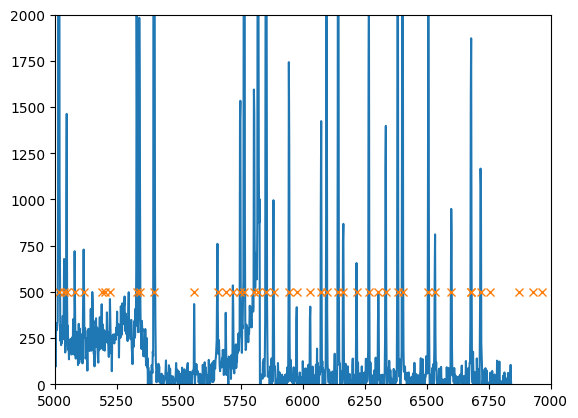

In [24]:
plt.plot(all_wavelengths, spectrum)
plt.plot(linelist['wave'], [500]*len(linelist['wave']), 'x')
plt.ylim([0,2000])
plt.xlim([5000,7000])

Now we'll use these lines as our first guess of where the lines actually are in the spectrum. We want to do this in pixel space, so first we'll tranlate the expected wavelengths into expected pixel positions using the fit we found from the He I lines. 

In [25]:
# make the expected wavelengths the first guess
make_x = np.floor((linelist['wave'] - linfit_wlmodel.intercept.value) / linfit_wlmodel.slope.value)
# exclude lines that fall outside the pixel range of our data
w_in_data = np.where((make_x>0) & (make_x<xaxis.max()))
guess_x = make_x[w_in_data]

These are now our guesses for the central position of the emission lines. We can do better by looking for the intensity-weighted pixel coordinate in a small window around the expected line location. 

In [26]:
# improve pixel X-value guesses by taking the intensity-weighted coordinate (moment 1):
npixels = 10
improved_xval_guesses = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=spectrum[g-npixels:g+npixels] - np.median(spectrum))
                         for g in guess_x.astype(int)]

You can print out the improved guesses to see how much the estimated central position changed. 
We should plot our improved guesses on the original data to make sure things are still behaving as expected. 

(0.0, 1000.0)

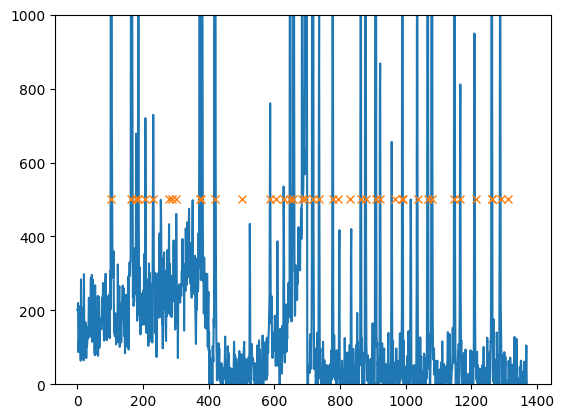

In [27]:
plt.plot(spectrum)
plt.plot(improved_xval_guesses, [500]*len(improved_xval_guesses), 'x')
plt.ylim([0,1000])

Now that we have much better sampling over the entire spectral range, let's refit the wavelength solution. 

In [28]:
# refit now using the whole spectrum 
full_linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=linelist['wave'][w_in_data])
new_wavelengths = full_linfit_wlmodel(np.arange(len(spectrum))) * u.AA
full_linfit_wlmodel

<Linear1D(slope=1.51306841, intercept=4770.04418075)>

We fit a linear model but this may not be the best choice. Play around with other functional forms (e.g., quadratic, cubic, quartic, ...) to see if it improves the fit. Hint: look at the residuals of the fit to make sure nothing went terribly wrong. 

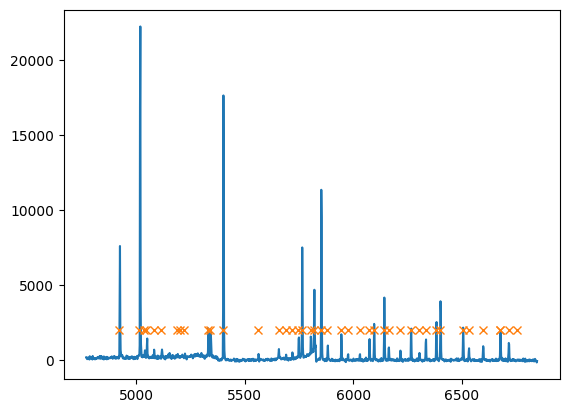

In [29]:
plt.plot(new_wavelengths, spectrum)
plt.plot(linelist['wave'][w_in_data], [2000]*len(linelist['wave'][w_in_data]), 'x')

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_25106/280830977.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("$\lambda(x)$")


Text(0.5, 0, 'x (pixels)')

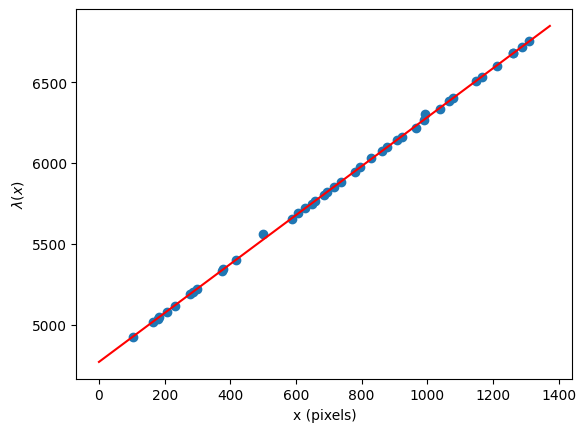

In [30]:
plt.plot(improved_xval_guesses, linelist['wave'][w_in_data], 'o')
plt.plot(xaxis, new_wavelengths, color='red')
plt.ylabel("$\lambda(x)$")
plt.xlabel("x (pixels)")

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  5., 31.,  3.,  1.]),
 array([-35.91397406, -30.85966104, -25.80534803, -20.75103502,
        -15.69672201, -10.64240899,  -5.58809598,  -0.53378297,
          4.52053004,   9.57484305,  14.62915607]),
 [<matplotlib.patches.Polygon at 0x149786f30>])

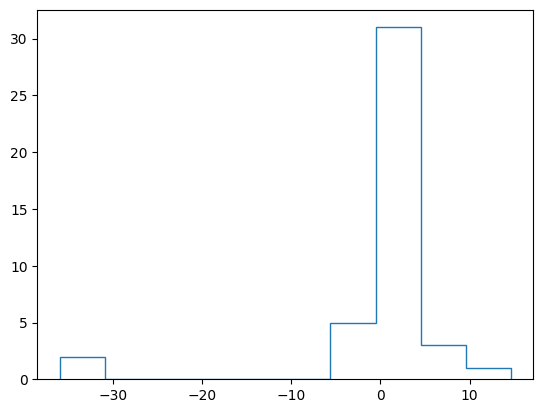

In [31]:
residuals_full_lamp_model = np.array(full_linfit_wlmodel(improved_xval_guesses) - linelist['wave'][w_in_data])
plt.hist(residuals_full_lamp_model, label='Full lamp fit', histtype='step')

If all went well, you should have an RMS of less than an Angstrom. If you don’t, check your line identifications. 

In [32]:
rms = np.sqrt(np.mean(residuals_full_lamp_model)**2)

In [33]:
rms

2.8800665556142726e-12

This is still only the wavelength solution of the detector along the row we defined as "middle." Notice that the arc lines are slightly tilted and curved. To get an accurate wavelength solution, we need to account for this by finding the wavelength solution for different y-values on the detector. 

# Full wavelength solution. 

First, lets look again at our composite lamp spectrum. Notice that the lines are tilted and slightly curved. We'll correct for this later. 

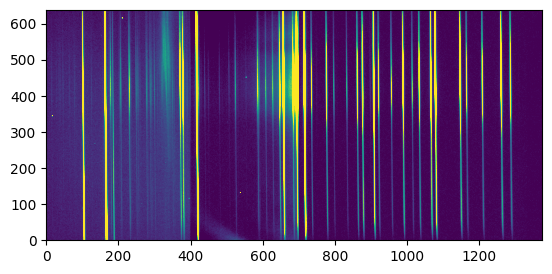

In [34]:
plt.imshow(spectrum2D, origin='lower', vmin=0, vmax=1500)

We will compute the wavelength solution for every row in the data. Below, we make the assumption that the tilt and curvature vary slowly so we can use the best-fit x-positions from the previous row as the starting guesses for the next row. Since we started with a slice through the middle of the data we'll do this in two parts: (1) starting in the middle and moving to the top of the chip and (2) starting in the middle and moving to the bottom. 

In [35]:
# fit wavelengths as the input coordinate 

yaxis=np.arange(spectrum2D.shape[0])
xvals=np.zeros([spectrum2D.shape[0],spectrum2D.shape[1]])
wavelengths = np.zeros((yaxis.shape[0],len(xaxis)))

xcntrs = np.zeros([spectrum2D.shape[0],w_in_data[0].shape[0]])
xcntrs[middle,:] = improved_xval_guesses
# 
slope = full_linfit_wlmodel.slope.value
intercept = full_linfit_wlmodel.intercept.value

# from middle to the top of the array 
last_guesses = (full_linfit_wlmodel(improved_xval_guesses) - intercept) / slope
wavelengths[middle,:] = new_wavelengths

for ii in yaxis[middle:]:
    improved_xguesses = [np.average(xaxis[g-npixels:g+npixels],
                                   weights=spectrum2D[ii,g-npixels:g+npixels])# - np.median(spectrum2D[ii,:]))
                        for g in np.floor(last_guesses).astype(int)]
    last_guesses = improved_xguesses
    xcntrs[ii,:] = improved_xguesses
    linfit_wlmodel = linfitter(model=wlmodel, x=improved_xguesses, y=linelist['wave'][w_in_data])
    xvals[ii,:] = (linfit_wlmodel(xaxis) - intercept) / slope
    wv_fit = linfit_wlmodel(xaxis) * u.AA
    wavelengths[ii,:] = wv_fit

# from middle to the bottom of the array 
last_guesses = improved_xval_guesses

for ii in np.arange(300)[::-1]:
    improved_xguesses = [np.average(xaxis[g-npixels:g+npixels],
                                   weights=spectrum2D[ii,g-npixels:g+npixels])# - np.median(spectrum2D[ii,:]))
                        for g in np.floor(last_guesses).astype(int)]
    last_guesses = improved_xguesses
    xcntrs[ii,:] = improved_xguesses
    linfit_wlmodel = linfitter(model=wlmodel, x=improved_xguesses, y=linelist['wave'][w_in_data])
    xvals[ii,:] = (linfit_wlmodel(xaxis) - intercept) / slope
    wv_fit = linfit_wlmodel(xaxis) * u.AA
    wavelengths[ii,:] = wv_fit


If everything went well, we should have an array with the same dimensions as our image with wavelengths increasing in the dispersion direction (to the right). 

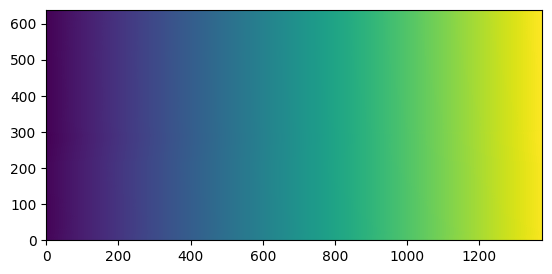

In [36]:
plt.imshow(wavelengths, origin='lower')

We want to use this 2D wavelength solution to straighten out the tilted and curved spectrum. To do this, we fit a surface. 

Finally, we can save the wavelength solution so that it is easy to use in subsequent steps. 

In [37]:
# make a header to store the units of the wavelength solution
hdr = fits.Header()
hdr['wvunit'] = 'Angstrom'

hdu = fits.PrimaryHDU(wavelengths, header=hdr)
hdul = fits.HDUList([hdu])
hdul.writeto('full_wave_sol.fits', overwrite=True)